In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 scipy tensorboard


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install pandas numpy scikit-learn tensorflow optuna matplotlib seaborn imbalanced-learn evaluate -q


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!nvidia-smi


Fri Jun  6 09:49:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               On  |   00000000:04:00.0 Off |                  Off |
|  0%   24C    P8             21W /  230W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install "numpy<2.0"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 61.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


Import Important Libraries

In [5]:
import warnings
import os
import shutil
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

from peft import LoraConfig, TaskType, get_peft_model  # For LoRA fine-tuning
import evaluate  # For additional evaluation metrics
import optuna  # For hyperparameter optimization
from transformers import BitsAndBytesConfig  # Helps with quantization
from tqdm import tqdm  # Progress bar for training and evaluation
from transformers import EarlyStoppingCallback
import pickle  # Save model artifacts



# Set CUDA_LAUNCH_BLOCKING for better error messages
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

2025-06-06 09:50:17.535000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 09:50:17.538762: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 09:50:17.550933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749203417.571108     361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749203417.577469     361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749203417.592811     361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Data Preprocessing

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict

# Update the path to the dataset stored on RunPod.io
# For example, if the dataset is stored in a directory called 'data' on your instance:
data_path = "/workspace/synthetic_mobile_money_transaction_dataset (2).csv"  # Adjust the path as needed

# Load the dataset
data = pd.read_csv(data_path)

# Assuming 'isFraud' is the label column and other columns are transaction details
data.rename(columns={'isFraud': 'label'}, inplace=True)

# Encode labels (0: Legitimate, 1: Suspicious)
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Convert transaction details into text format
text_columns = ['step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator', 'newBalInitiator', 'recipient', 'oldBalRecipient', 'newBalRecipient']
data['text'] = data[text_columns].astype(str).agg(' '.join, axis=1)

# Keep only necessary columns
data = data[['label', 'text']]

# Split into training (80%), validation (10%), and test (10%) sets
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])



# Use the entire dataset (no random sampling)
train_df_small = train_df
val_df_small = val_df
test_df_small = test_df


# Reset index
def reset_index(df):
    return df.reset_index(drop=True)

train_df_small = reset_index(train_df_small)
val_df_small = reset_index(val_df_small)
test_df_small = reset_index(test_df_small)

# Convert to Hugging Face Dataset format
train_dataset_small = Dataset.from_pandas(train_df_small)
valid_dataset_small = Dataset.from_pandas(val_df_small)
test_dataset_small = Dataset.from_pandas(test_df_small)

dataset_dict_small = DatasetDict({
    "train": train_dataset_small,
    "valid": valid_dataset_small,
    "test": test_dataset_small
})

# Display dataset info for the smaller subset
print(dataset_dict_small)
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3380766
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 422596
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 422596
    })
})
Label mapping: {0: 0, 1: 1}


Setting hyperparameters for training the models

In [7]:
learning_rate=5e-5
batch_size=8
num_epochs=5

In [ ]:
Important Functions 

In [10]:
# Define text preprocessing
def preprocess_function(examples, tokenizer):
    return tokenizer(examples["text"], max_length=134, padding='max_length', truncation=True)

# Tokenize all datasets
def tokenize_data(dataset_dict, tokenizer):
    return dataset_dict.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)

# Create data collator
def create_data_collator(tokenizer):
    return DataCollatorWithPadding(tokenizer=tokenizer)

# Load metrics
def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy")
    auc_score = evaluate.load("roc_auc")

    # Get predictions
    predictions, labels = eval_pred

    # Apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)

    # Use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]

    # Compute AUC
    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'], 3)

    # Predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)

    # Compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'], 3)

    return {"Accuracy": acc, "AUC": auc}

# Function to evaluate model on test data
def evaluate_model_on_test(trainer, tokenized_test_dataset, label_encoder, model_name):
    """
    Evaluate the trained model on tokenized test data and display results.

    Args:
        trainer (Trainer): Hugging Face Trainer object.
        tokenized_test_dataset (Dataset): Tokenized test dataset.
        label_encoder (LabelEncoder): LabelEncoder to get class names.
        model_name (str): Name of the model (used for saving files).

    Returns:
        None
    """
    # Create directory for saving evaluation results
    results_dir = Path(f"results/{model_name}")
    results_dir.mkdir(parents=True, exist_ok=True)

    # Get predictions from the model on the tokenized dataset
    predictions = trainer.predict(tokenized_test_dataset)

    # Extract logits (raw predictions) and true labels
    logits, labels = predictions.predictions, predictions.label_ids
    predicted_classes = np.argmax(logits, axis=1)

    # Get class names
    label_names = ["legitimate", "fraud"]

    # Generate classification report
    class_report = classification_report(labels, predicted_classes, target_names=label_names, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()
    print("\nClassification Report:\n", class_report_df)

    # Save the classification report to CSV
    class_report_df.to_csv(results_dir / "classification_report.csv", index=True)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(labels, predicted_classes)

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.savefig(results_dir / "confusion_matrix.png")
    plt.show()

    # Plot ROC Curve
    probabilities = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    positive_class_probs = probabilities[:, 1]
    fpr, tpr, _ = roc_curve(labels, positive_class_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.savefig(results_dir / "roc_curve.png")
    plt.show()

# Function to create and train the model
def train_model(model, tokenizer, tokenized_data, learning_rate, batch_size, num_epochs, model_name):
    """
    Train the model, display training time, and save the model only at the end of training.

    Args:
        model: The model to train.
        tokenizer: Tokenizer for text preprocessing.
        tokenized_data: Tokenized dataset containing training and validation splits.
        learning_rate: Learning rate for the optimizer.
        batch_size: Batch size for training and evaluation.
        num_epochs: Number of training epochs.
        model_name: Name of the model (used for saving files).

    Returns:
        Trainer: Hugging Face Trainer object.
    """
    # Create directory for saving training results
    results_dir = Path(f"results/{model_name}")
    results_dir.mkdir(parents=True, exist_ok=True)

    # Hyperparameters
    training_args = TrainingArguments(
        output_dir=str(results_dir),  # Required but no automatic save
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="no",  # Disable automatic saving
        logging_dir=str(results_dir / "logs"),  # Optional: logging directory
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["valid"],
        tokenizer=tokenizer,
        data_collator=create_data_collator(tokenizer),
        compute_metrics=compute_metrics,
    )

    # Start timing the training process
    start_time = time.time()

    # Train the model
    trainer.train()

    # End timing and calculate training time
    end_time = time.time()
    training_time_minutes = round((end_time - start_time) / 60, 2)

    # Print the training time
    print(f"\nTotal Training Time: {training_time_minutes} minutes\n")

    # Save the model manually at the end of training
    model_save_path = results_dir / "final_model"
    trainer.save_model(str(model_save_path))
    print(f"Model saved to {model_save_path}")

    # Extract metrics
    metrics = trainer.state.log_history
    train_loss = [x['loss'] for x in metrics if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in metrics if 'eval_loss' in x]
    eval_accuracy = [x['eval_Accuracy'] for x in metrics if 'eval_Accuracy' in x]
    epochs = range(1, len(train_loss) + 1)


     # Plot training and evaluation metrics
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_dir / "loss_curve.png")
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, eval_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_dir / "accuracy_curve.png")
    plt.show()

    return trainer


Fine-tuning DistilBERT-Base; Updating only the Pooler layers and freezing all other layers

In [11]:
# Load model directly
model_path = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Legitimate", 1: "Suspicious"}
label2id = {"Legitimate": 0, "Suspicious": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

Map:   0%|          | 0/3380766 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.127900,0.092213,0.951000,0.995000
2,0.119600,0.085035,0.960000,0.995000
3,0.118100,0.082652,0.961000,0.995000
4,0.116300,0.082160,0.959000,0.996000
5,0.114600,0.082092,0.960000,0.995000


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Total Training Time: 515.59 minutes

Model saved to results/distilbert_only_pooler_layer_unfreezed/final_model


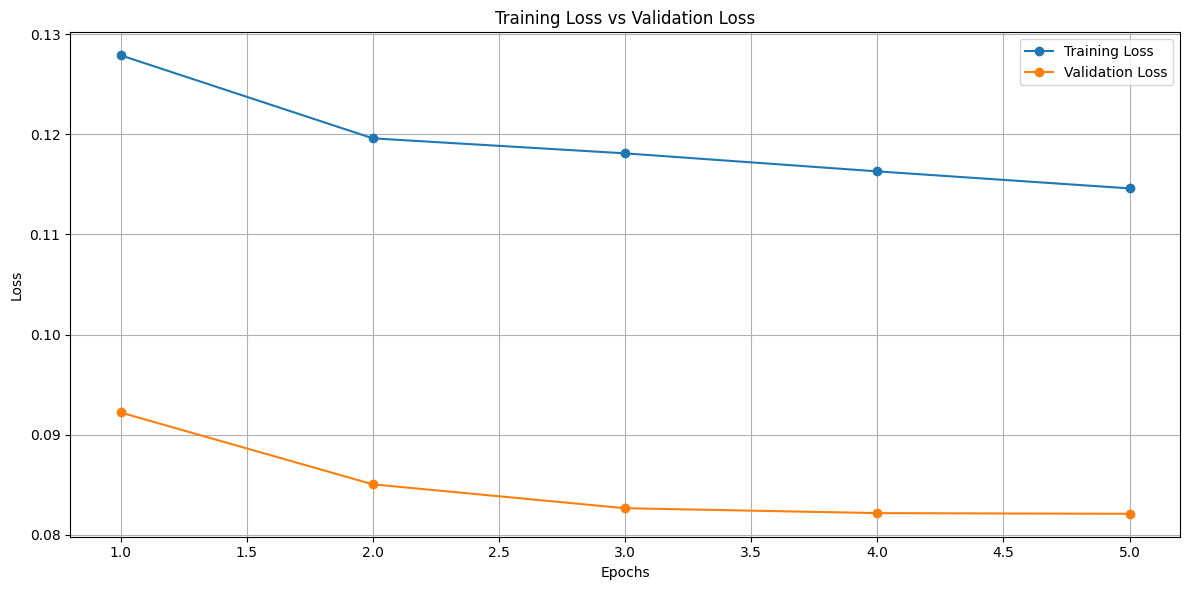

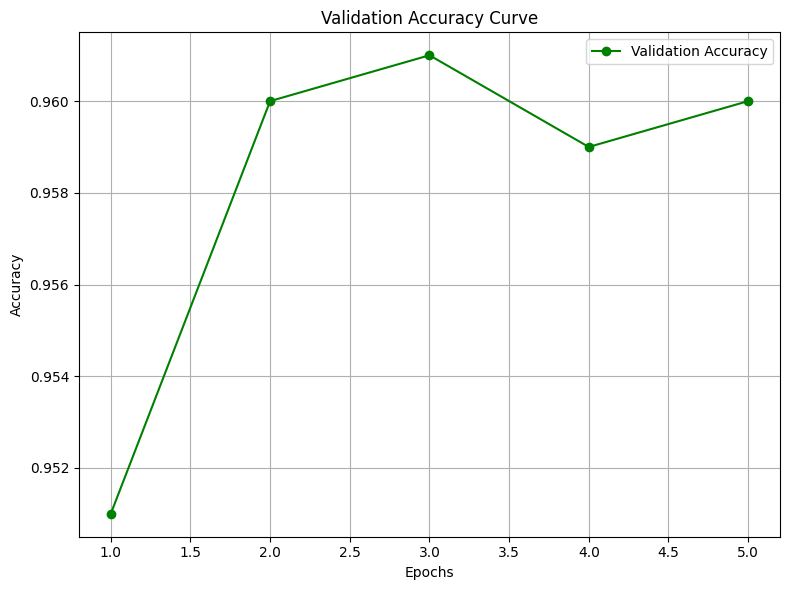


Classification Report:
               precision    recall  f1-score        support
legitimate     0.949469  0.968231  0.958758  199284.000000
fraud          0.971141  0.954015  0.962502  223312.000000
accuracy       0.960719  0.960719  0.960719       0.960719
macro avg      0.960305  0.961123  0.960630  422596.000000
weighted avg   0.960921  0.960719  0.960736  422596.000000


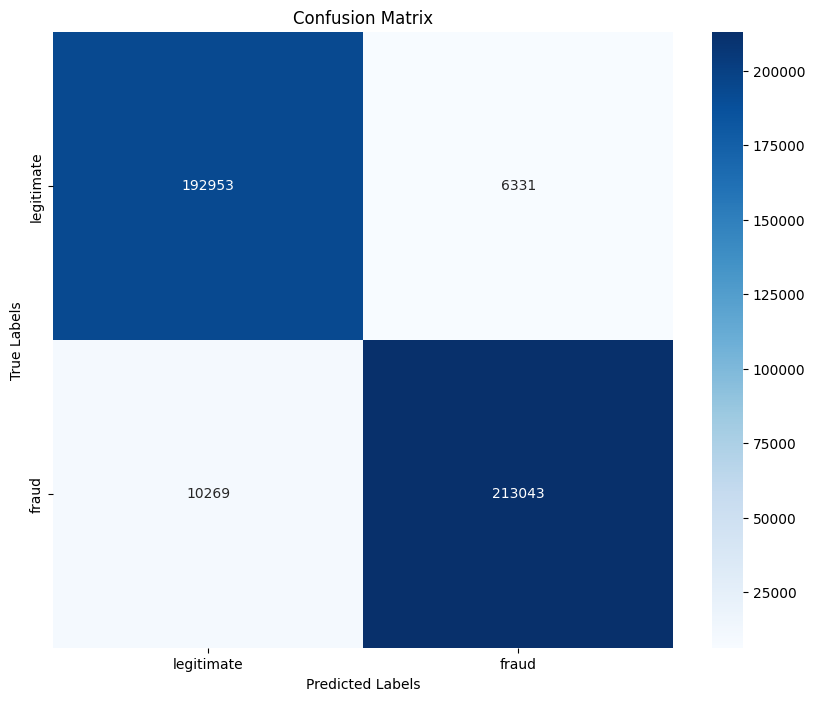

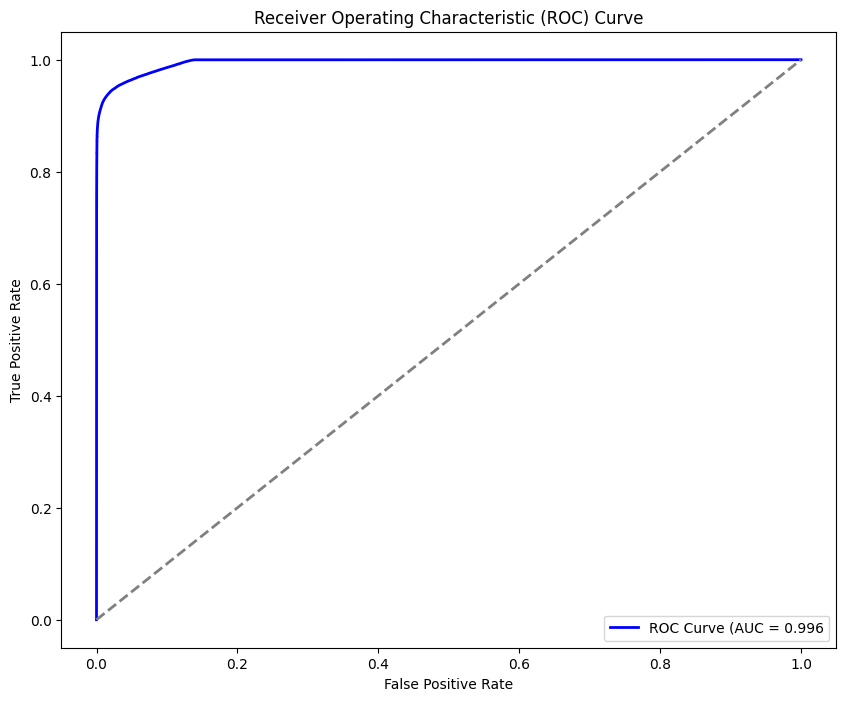

In [13]:
model_name="distilbert_only_pooler_layer_unfreezed"
tokenized_data = tokenize_data(dataset_dict_small, tokenizer)
trainer=train_model(model, tokenizer,  tokenized_data, learning_rate, batch_size, num_epochs,model_name)
evaluate_model_on_test(trainer, tokenized_data["test"], label_encoder,model_name)

In [14]:
# Save model
save_dir = "results/phase1_distilbert_only_pooler_layer_unfreezed"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('results/phase1_distilbert_only_pooler_layer_unfreezed/tokenizer_config.json',
 'results/phase1_distilbert_only_pooler_layer_unfreezed/special_tokens_map.json',
 'results/phase1_distilbert_only_pooler_layer_unfreezed/vocab.txt',
 'results/phase1_distilbert_only_pooler_layer_unfreezed/added_tokens.json',
 'results/phase1_distilbert_only_pooler_layer_unfreezed/tokenizer.json')

Applying SHAP

In [16]:
# Install Required Libraries
!pip install shap transformers torch


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.3/992.3 kB 7.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 71.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
# Load the Fine-Tuned Model and Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load your saved model
model_dir = "results/phase1_distilbert_only_pooler_layer_unfreezed"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
model.eval().cuda()  # move to GPU if available


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Load tokenizer and model
model_path = "results/phase1_distilbert_only_pooler_layer_unfreezed"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# 2. Create a Hugging Face text classification pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 3. Wrap pipeline in SHAP Explainer
explainer = shap.Explainer(pipe)

# 4. Input must be a list of complete strings
sample_texts = [
    "A transfer of $39.03 was made by the initiator with a starting balance of $39.03, leaving them with $0.00. The recipient's balance increased from $55.94 to $94.98."
]

# 5. Compute SHAP values
shap_values = explainer(sample_texts)

# 6. Visualize (e.g., bar plot)
shap.plots.text(shap_values[0])


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:01, 61.80s/it]               


Fine-tuning DistilBERT-Base; Updating all the layers

In [32]:
# Load model directly
model_path = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Legitimate", 1: "Suspicious"}
label2id = {"Legitimate": 0, "Suspicious": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
for param in model.parameters():
    param.requires_grad = True

In [35]:
from IPython.display import clear_output
clear_output(wait=True)


In [ ]:
#trainer


In [ ]:
#evaluate_model_on_test(trainer, tokenized_data["test"], label_encoder, model_name)


Map:   0%|          | 0/3380766 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.147400,0.761466,0.851000,0.851000
2,0.143200,0.116566,0.959000,0.994000
3,0.136900,0.086562,0.962000,0.995000
4,0.118300,0.140316,0.962000,0.995000
5,0.130100,0.114013,0.964000,0.996000


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Total Training Time: 1452.7 minutes

Model saved to results/distilbert_all_layer_unfreezed/final_model


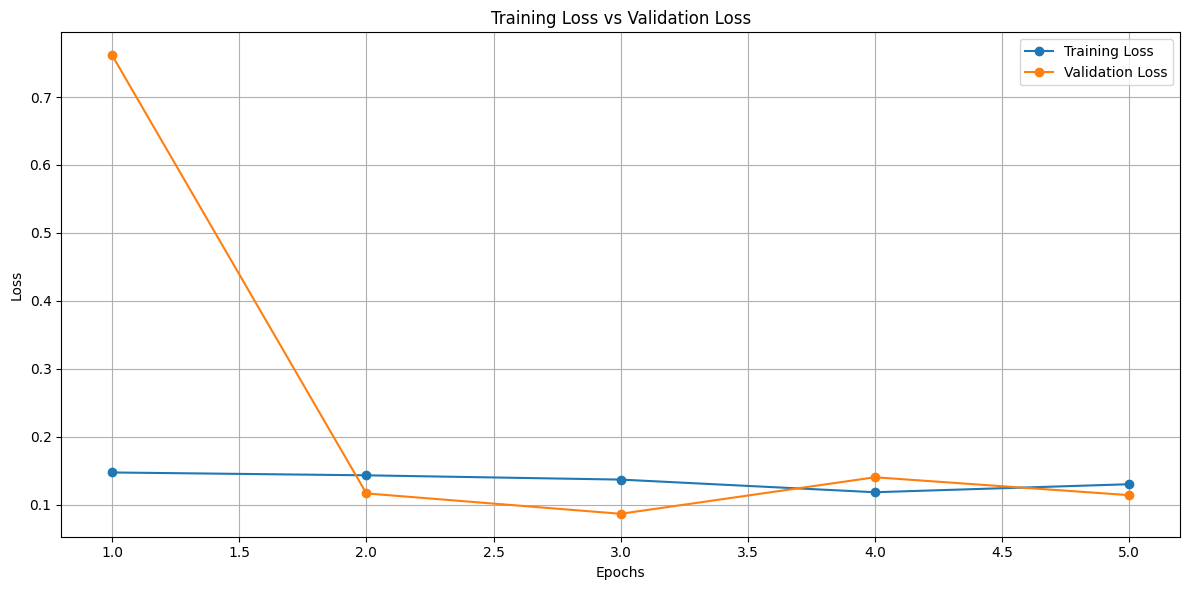

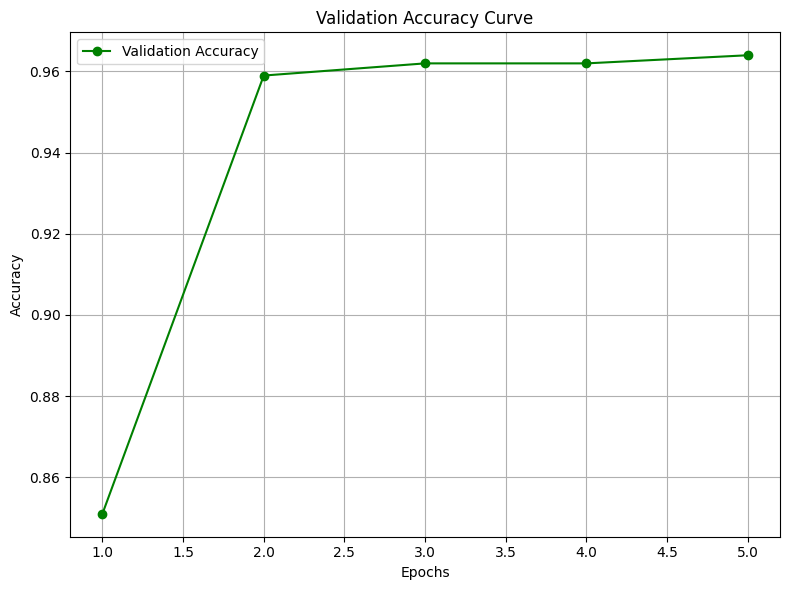


Classification Report:
               precision    recall  f1-score        support
legitimate     0.940833  0.985839  0.962811  199284.000000
fraud          0.986799  0.944674  0.965277  223312.000000
accuracy       0.964086  0.964086  0.964086       0.964086
macro avg      0.963816  0.965257  0.964044  422596.000000
weighted avg   0.965123  0.964086  0.964114  422596.000000


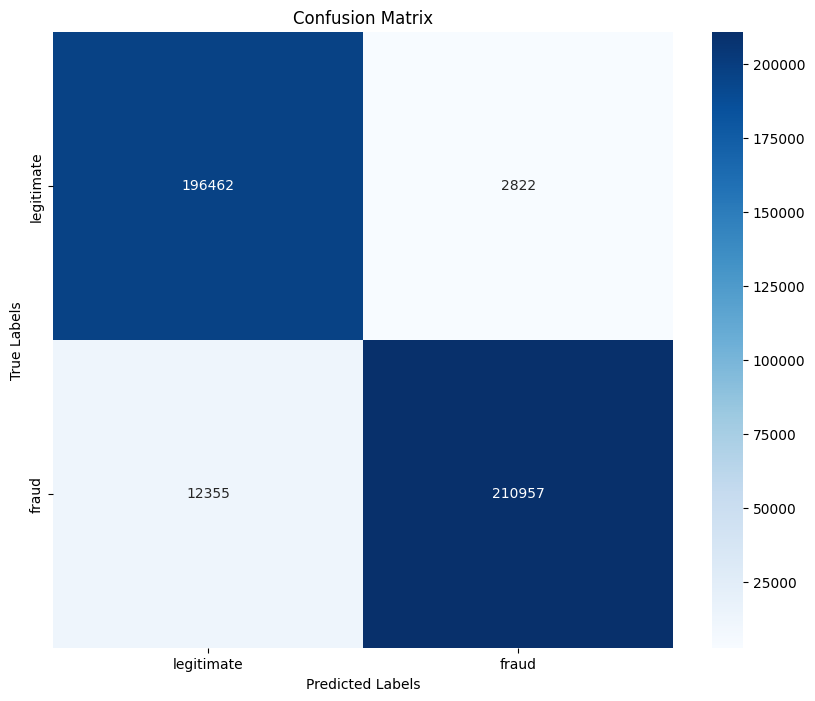

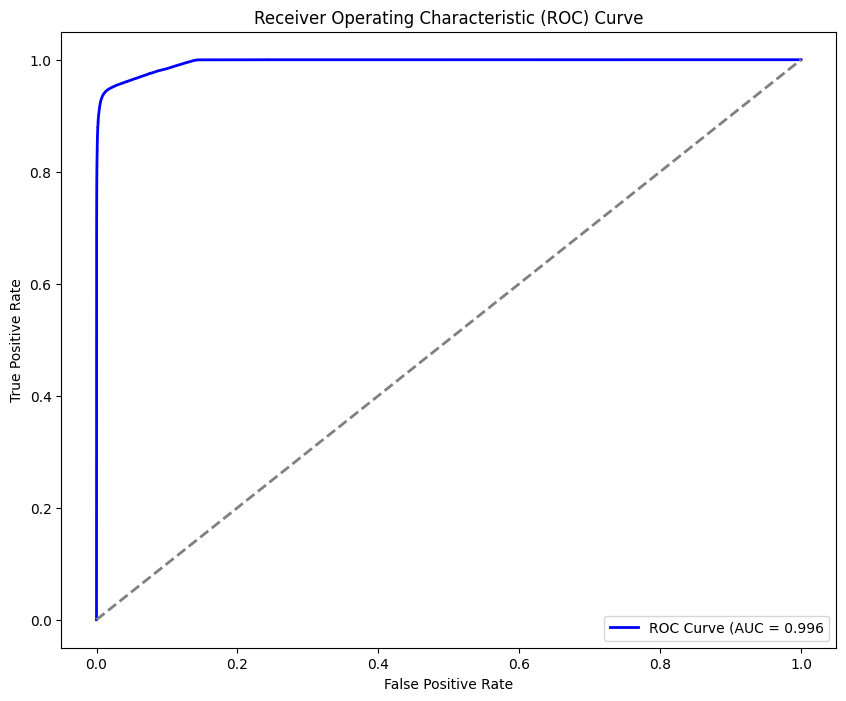

In [36]:
model_name="distilbert_all_layer_unfreezed"
tokenized_data = tokenize_data(dataset_dict_small, tokenizer)
trainer=train_model(model, tokenizer,  tokenized_data, learning_rate, batch_size, num_epochs,model_name)
evaluate_model_on_test(trainer, tokenized_data["test"], label_encoder,model_name)

Saving the model

In [37]:
# Save model
save_dir = "results/phase2_distilbert_all_layer_unfreezed"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('results/phase2_distilbert_all_layer_unfreezed/tokenizer_config.json',
 'results/phase2_distilbert_all_layer_unfreezed/special_tokens_map.json',
 'results/phase2_distilbert_all_layer_unfreezed/vocab.txt',
 'results/phase2_distilbert_all_layer_unfreezed/added_tokens.json',
 'results/phase2_distilbert_all_layer_unfreezed/tokenizer.json')

Applying SHAP

In [38]:
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Load tokenizer and model
model_path = "results/phase2_distilbert_all_layer_unfreezed"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# 2. Create a Hugging Face text classification pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 3. Wrap pipeline in SHAP Explainer
explainer = shap.Explainer(pipe)

# 4. Input must be a list of complete strings
sample_texts = [
    "A transfer of $39.03 was made by the initiator with a starting balance of $39.03, leaving them with $0.00. The recipient's balance increased from $55.94 to $94.98."
]

# 5. Compute SHAP values
shap_values = explainer(sample_texts)

# 6. Visualize (e.g., bar plot)
shap.plots.text(shap_values[0])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:59, 59.08s/it]               


Applying LoRA technique to DistilBERT-Base Model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3380766 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

Map:   0%|          | 0/422596 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.068900,0.064839,0.972000,0.996000
2,0.064400,0.063418,0.972000,0.996000
3,0.064400,0.062629,0.973000,0.997000
4,0.065000,0.061963,0.973000,0.996000
5,0.067700,0.062478,0.973000,0.997000



Total Training Time: 1149.1 minutes

Model saved to results/distilbert_Lora/final_model


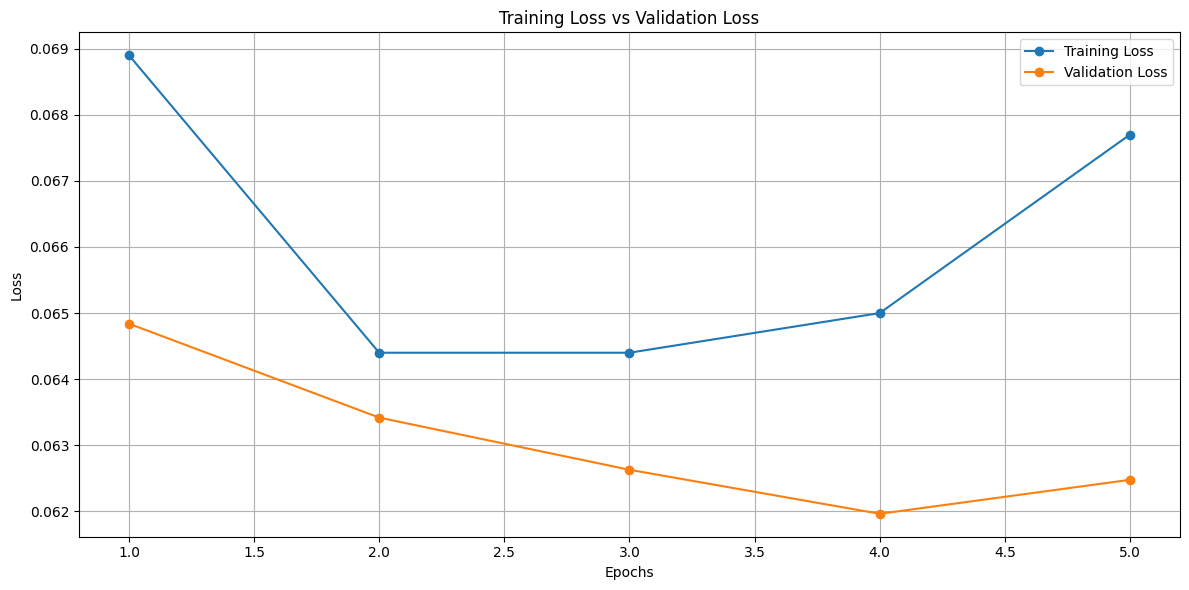

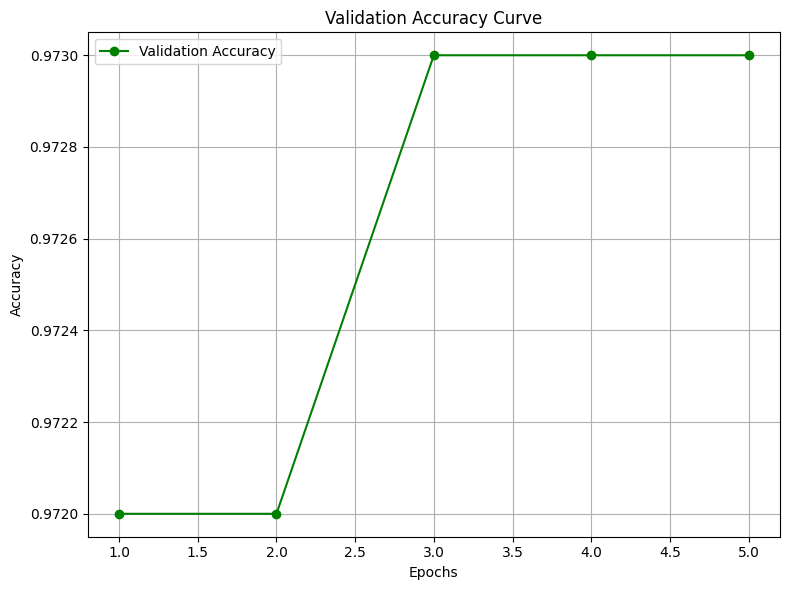


Classification Report:
               precision    recall  f1-score        support
legitimate     0.945564  0.999493  0.971781  199284.000000
fraud          0.999523  0.948650  0.973423  223312.000000
accuracy       0.972626  0.972626  0.972626       0.972626
macro avg      0.972544  0.974072  0.972602  422596.000000
weighted avg   0.974078  0.972626  0.972648  422596.000000


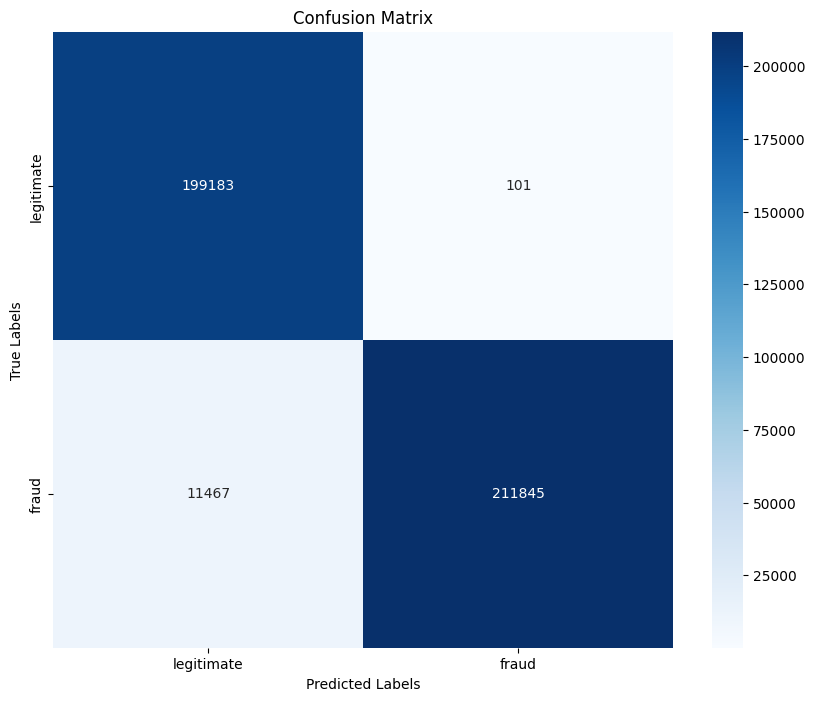

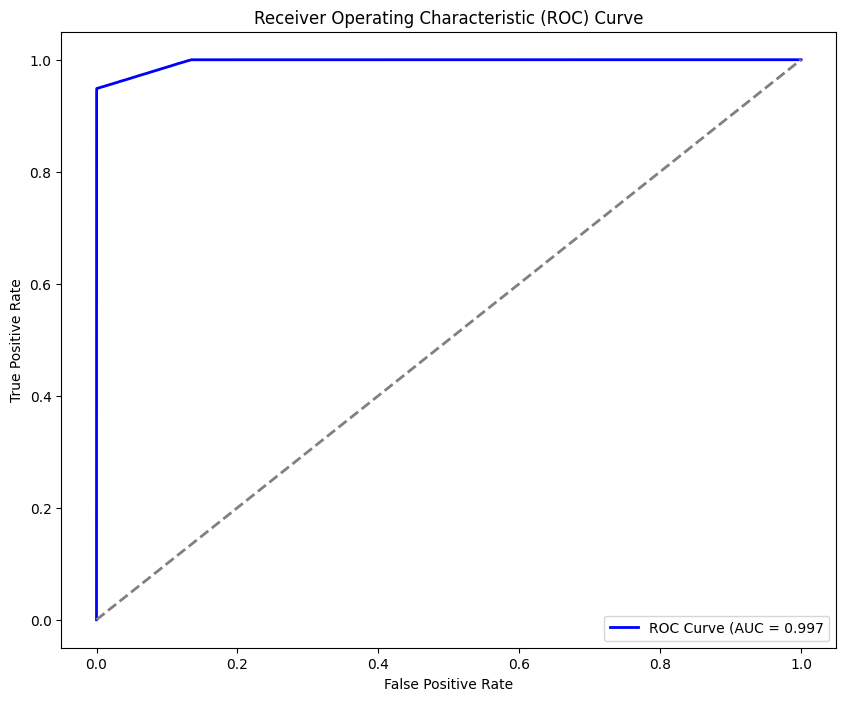

In [39]:
# Import necessary libraries
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType

# Clear excessive logs
clear_output(wait=True)

# Define the model ID and load tokenizer
model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Define the PEFT LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]  # Example for DistilBERT
)

# Load the model and apply PEFT LoRA configuration
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
model = get_peft_model(model, peft_config)

model_name = "distilbert_Lora"

# Tokenize the data
tokenized_data = tokenize_data(dataset_dict_small, tokenizer)

# Define custom training arguments with reduced logging
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    logging_steps=500,  # Log every 500 steps instead of every step
    logging_strategy="steps"
)

# Train the model
trainer = train_model(model, tokenizer, tokenized_data, learning_rate, batch_size, num_epochs, model_name)

# Evaluate the model
evaluate_model_on_test(trainer, tokenized_data["test"], label_encoder, model_name)


Saving the model

In [40]:
# Save model
save_dir = "results/phase3_distilbert_Lora"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('results/phase3_distilbert_Lora/tokenizer_config.json',
 'results/phase3_distilbert_Lora/special_tokens_map.json',
 'results/phase3_distilbert_Lora/vocab.txt',
 'results/phase3_distilbert_Lora/added_tokens.json',
 'results/phase3_distilbert_Lora/tokenizer.json')

Applying SHAP

In [43]:
import torch
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from peft import PeftModel

# 1. Load base model and tokenizer
base_model_name = "distilbert-base-uncased"  # or whatever base model you used
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_name)

# 2. Load the LoRA adapter
model = PeftModel.from_pretrained(base_model, "results/phase3_distilbert_Lora")
model.eval()

# 3. Create pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# 4. SHAP explainer
explainer = shap.Explainer(pipe)

# 5. Input
sample_texts = [
    "A transfer of $39.03 was made by the initiator with a starting balance of $39.03, leaving them with $0.00. The recipient's balance increased from $55.94 to $94.98."
]

# 6. Compute SHAP values
shap_values = explainer(sample_texts)

# 7. Visualize
shap.plots.text(shap_values[0])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:15, 75.13s/it]               
